In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer


In [82]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from functools import partial

## Functions

In [110]:
def get_scores(data, tag='RF', ax=None, target_specificty=0.7):
    target_fpr = 1 - target_specificty
    tags = [col[:-5] for col in data.columns if 'pred' in col]
    results = pd.DataFrame()
    results['metric'] = ["AUROC", "Sensitivity", "Specificity", "F1"]
    for tag in tags:
        auroc = roc_auc_score(data['outcome'], data[tag+'_pred'])
        fpr, tpr, thresholds = roc_curve(data['outcome'], data[tag+'_pred'])
        idx = np.where(fpr>=target_fpr)[0][0]
        sensitivity = np.interp(target_fpr, fpr[idx-1:idx+1], tpr[idx-1:idx+1])
        threshold = np.interp(target_fpr, fpr[idx-1:idx+1], thresholds[idx-1:idx+1])
        print(threshold, fpr[idx-1:idx+1], thresholds[idx-1:idx+1])
        report = classification_report(data['outcome'], data[tag+'_pred']>=threshold, output_dict=True)
        f1 = report['1']['f1-score']
        results[tag] = [auroc, sensitivity, target_specificty, f1]
        
        roc_display = RocCurveDisplay.from_predictions(data['outcome'], data[tag+'_pred'], name=tag, ax=ax)
        ax = roc_display.ax_
    return results, roc_display

def drop_cols(data, cols2drop, impute=False, na_indicator=False):
    default_cols = ["outcome", "STAY_ID", "orig_stay_id"]
    if cols2drop is not None:
        default_cols += cols2drop
    x = data.drop(columns=default_cols)
    x = x[[col for col in x.columns if "pred" not in col]]
    if impute:
        if not na_indicator:
            x[:] = KNNImputer(add_indicator=na_indicator).fit_transform(x)
        else:
            x = KNNImputer(add_indicator=na_indicator).fit_transform(x)
    return x

In [109]:
def get_random_forest(data, cv=10, scoring='f1', n_jobs=8, tag="RF", cols2drop=None, ft_importance=None, impute=False, na_indicator=False):
    y = data["outcome"]
    x = drop_cols(data, cols2drop=cols2drop, impute=impute, na_indicator=na_indicator)
    
    rfc = RandomForestClassifier(random_state=44)
    param_grid = { 
        'n_estimators': [500, 1000, 1500, 2000],
        'max_features': ['auto'],
        'max_depth' : [13, 17, 20, 22, 24],
        'criterion' :['entropy', 'gini']
    }
    cv_crf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring=scoring, n_jobs=n_jobs)
    cv_crf.fit(x, y)
    rfc = RandomForestClassifier(random_state=44, **cv_crf.best_params_)
    print(cv_crf.best_params_)
    prediction = cross_val_predict(rfc, x, y, cv=cv, method='predict_proba', n_jobs=n_jobs)
    prediction_score = prediction[:,1]/(prediction[:,0]+prediction[:,1])
    data[tag+'_pred'] = prediction_score
    rfc.fit(x, y)
    if not na_indicator:
        if ft_importance is None:
            ft_importance = pd.DataFrame()
            ft_importance['features'] = x.columns
        ft_importance[tag] = rfc.feature_importances_
    return data, ft_importance

In [133]:
from xgboost import XGBClassifier

def get_xgb(data, tag='XGBoost', n_jobs=8, tune_hp=False, cols2drop=None, ft_importance=None, impute=False, na_indicator=False):
    
    y = data["outcome"]
    x = drop_cols(data, cols2drop=cols2drop, impute=impute, na_indicator=na_indicator)
    
    scaler = StandardScaler()
    scaler = scaler.fit(x)
    transformed_x = scaler.transform(x)
    
    hyperparams = get_best_params(x, y)
    print(hyperparams)
    
    xgbc = XGBClassifier(**hyperparams)
    prediction = cross_val_predict(xgbc, x, y, cv=5, method='predict_proba', n_jobs=8)
    prediction_score = prediction[:,1]/(prediction[:,0]+prediction[:,1])
    data[tag+'_pred'] = prediction_score
    
    xgbc.fit(x, y)
    if not na_indicator:
        if ft_importance is None:
            ft_importance = pd.DataFrame()
            ft_importance['features'] = x.columns
        ft_importance[tag] = xgbc.feature_importances_
    
    return data, ft_importance

def objective(space, data):
    X_train, X_test, y_train, y_test = data
    clf=XGBClassifier(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],min_child_weight=int(space['min_child_weight']), reg_lambda = space['reg_lambda'],
                    colsample_bytree=space['colsample_bytree'], use_label_encoder=False, eval_metric="auc",  
                    early_stopping_rounds=20, n_jobs=10)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, verbose=False)
    

    pred = clf.predict_proba(X_test)
    accuracy = roc_auc_score(y_test, pred[:,1])
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

def get_best_params(x, y):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    
    space={'max_depth': hp.quniform("max_depth", 16, 30, 1),
            'gamma': hp.uniform ('gamma', 2,3),
            'reg_alpha' : hp.quniform('reg_alpha', 7,15,1),
            'reg_lambda' : hp.uniform('reg_lambda', 0.5,0.8),
            'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,0.7),
            'min_child_weight' : hp.quniform('min_child_weight', 1, 7, 1),
            'n_estimators': hp.quniform('n_estimators',900,1200,1),
            'seed': 0
        }
    trials = Trials()
    fn = partial(objective, data=(X_train, X_test, y_train, y_test))
    hyperparams = fmin(fn = fn,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = 200,
                            trials = trials)
    for key, value in hyperparams.items():
        if int(value) == value:
            hyperparams[key] = int(value)
    return hyperparams
    

In [107]:
def get_regression(data, cv=10, tag="LR", cols2drop=None, n_jobs=8, ft_importance=None, impute=False, na_indicator=False):
    y = data["outcome"]
    x = drop_cols(data, cols2drop=cols2drop, impute=impute, na_indicator=na_indicator)
    
    scaler = StandardScaler()
    scaler = scaler.fit(x)
    transformed_x = scaler.transform(x)
    
    model = LogisticRegression(max_iter=500)
    
    prediction = cross_val_predict(model, transformed_x, y, cv=cv, method='predict_proba', n_jobs=n_jobs)
    prediction_score = prediction[:,1]/(prediction[:,0]+prediction[:,1])
    data[tag+'_pred'] = prediction_score
    model.fit(x, y)
    if not na_indicator:
        if ft_importance is None:
            ft_importance = pd.DataFrame()
            ft_importance['features'] = x.columns
        importances = np.abs(np.array(model.coef_[0]))
        importances = importances/ importances.sum()
        ft_importance[tag] = importances

    return data, ft_importance
    
    

In [75]:
def get_nld_score(data, tag="NLD"):
    best_possible_score = 15
    clean_airway = (data["airway"] == 0).astype(int)
    good_fio2 = (data["fio2"] <= 60).astype(int)
    good_hco3 = (data["hco3"] >= 19).astype(int)
    good_resp_min = (data["resp_min"] >= 10).astype(int)
    good_resp_max = (data["resp_max"] <= 30).astype(int)
    good_bp_max = (data["bp_max"] >= 100).astype(int)
    good_pain = (data["pain"] <= 1).astype(int)
    good_gcs =  (data["gcs_min"] > 3).astype(int)
    good_temp_min = (data["temp_min"] >= 36).astype(int)
    good_temp_max = (data["temp_max"] <= 37.5).astype(int)
    good_hg = (data["haemoglobin"] >= 9.0).astype(int)
    good_k = ((data["k"] >= 3.5).astype(int)) & ((data["k"] <= 6.0).astype(int))
    good_na = ((data["na"] >= 130).astype(int)) & ((data["na"] <= 150).astype(int))
    good_cr = ((data["creatinine"] >= 59).astype(int)) & ((data["creatinine"] <= 104).astype(int))
    good_bun = ((data["bun"] >= 2.5).astype(int)) & ((data["bun"] <= 7.8).astype(int))
    all_variable = clean_airway + good_fio2 + good_hco3 + good_resp_min + good_resp_max + good_bp_max + good_pain + \
                    good_gcs + good_temp_min + good_temp_max + good_hg + good_k + good_na + good_cr + good_bun
    data[tag + '_pred'] = all_variable/best_possible_score
    return data

In [76]:
EXTENDED=["ethnicity", "gender", "admission_age", "los_icu", "weight", "bmi"]

## Missing Values

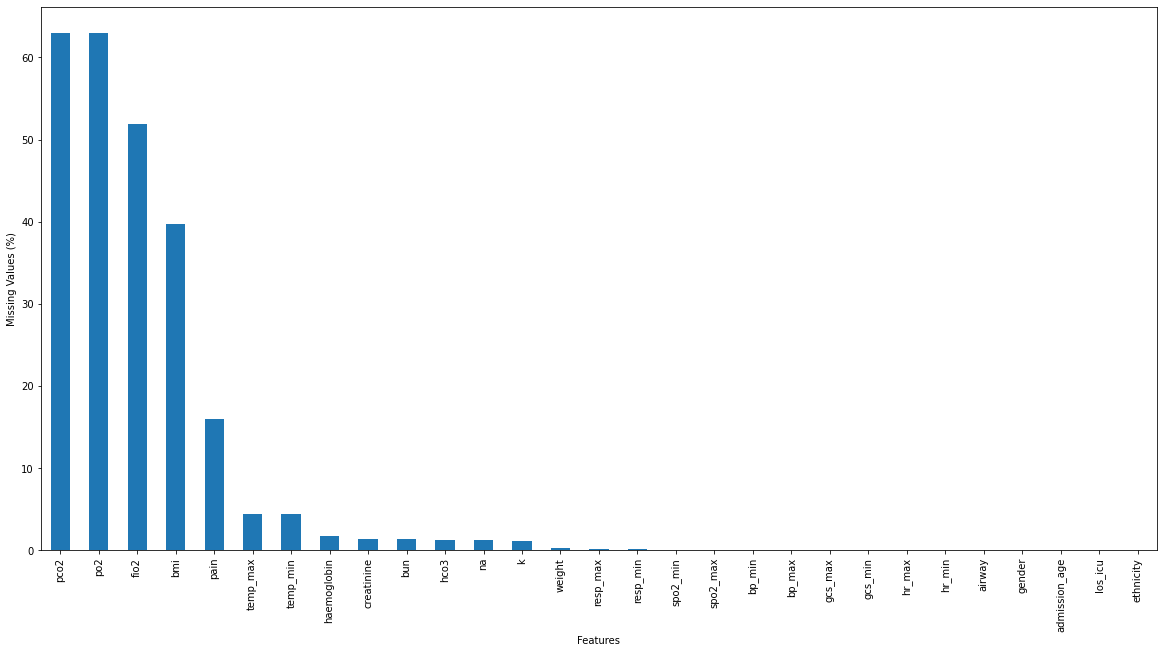

In [83]:
data = pd.read_pickle("mimic-iii/Feature_Matrix_MIMIC_with_missing_values_extended.pkl")
a = (data.drop(columns=["outcome", "orig_stay_id", "STAY_ID"]).isna().sum()/len(data)*100) #.plot(kind="bar")
fig = a.sort_values(ascending=False).plot(kind="bar", xlabel="Features", ylabel="Missing Values (%)")
plt.savefig("mimic-iii/missing_value_plot.png")

## Complete Case

In [134]:
data = pd.read_pickle("mimic-iii/Feature_Matrix_MIMIC_with_missing_values_extended.pkl")
data = data.drop(columns=EXTENDED)
data = data.drop(columns=['po2', 'pco2'])
data = data.dropna(how='any')
data = data.sample(frac=1)

print(f"Total Samples: {len(data)}")
print(f"RFD: {len(data[data['outcome']==1])}")
print(f"Not RFD: {len(data[data['outcome']==0])}")

data = get_nld_score(data)

data, ft_importance = get_regression(data, tag='LR')

data, ft_importance = get_random_forest(data, tag='RF', n_jobs=12, ft_importance=ft_importance)

data, ft_importance = get_xgb(data, tag='XGBoost' ,ft_importance=ft_importance)

Total Samples: 6409
RFD: 2289
Not RFD: 4120


/Users/azhar.sultan/opt/anaconda3/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'criterion': 'gini', 'max_depth': 17, 'max_features': 'auto', 'n_estimators': 1000}
SCORE:                                                                                                                                                                                                              
0.9023755854315738                                                                                                                                                                                                  
SCORE:                                                                                                                                                                                                              
0.8990985892815708                                                                                                                                                                                                  
SCORE:                                                         

0.805541346973572 [0.12597087 0.3157767 ] [0.86666667 0.8       ]
0.1976172463072736 [0.29563107 0.30097087] [0.20437318 0.19611593]
0.2535412171714933 [0.29975728 0.30048544] [0.25377799 0.25306767]
0.16262823343276978 [0.29951456 0.30024272] [0.16277948 0.16255261]


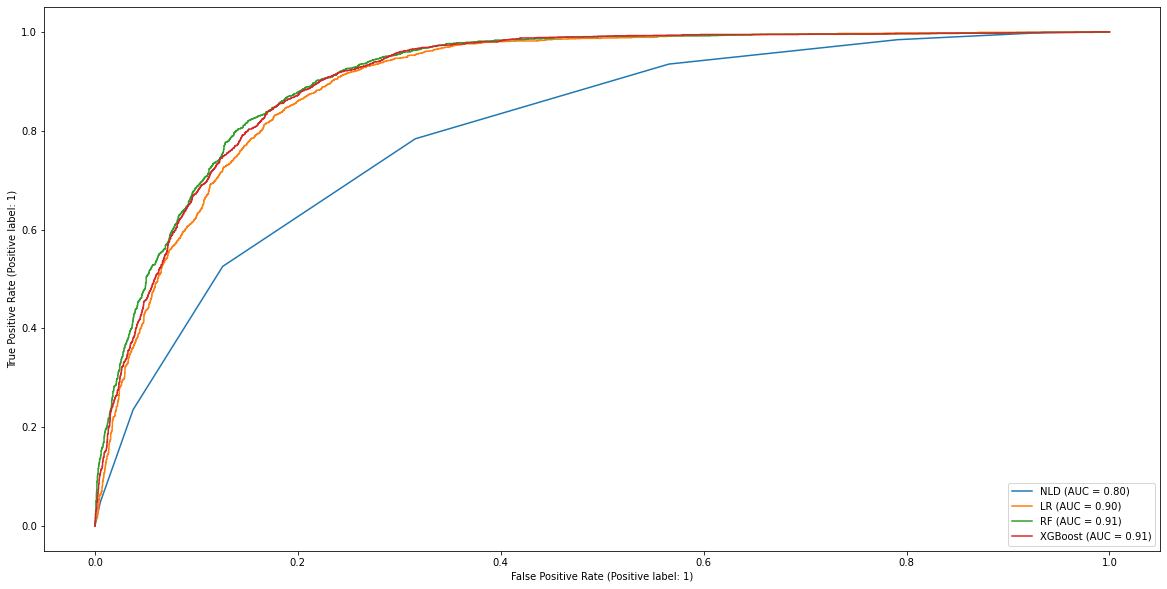

In [135]:
results, display = get_scores(data, target_specificty=0.7)

results.to_pickle("mimic-iii/cc_results.pkl")
ft_importance.to_pickle("mimic-iii/cc_feature_importance.pkl")

5699

In [118]:
results.set_index("metric", drop=True).transpose().to_clipboard(float_format='%1.3f')

In [117]:
results.transpose()

,0,1,2,3
metric,AUROC,Sensitivity,Specificity,F1
NLD,0.80126,0.762287,0.7,0.59985
LR,0.900211,0.948886,0.7,0.762774
RF,0.913215,0.958497,0.7,0.767401
XGBoost,0.910284,0.953255,0.7,0.764809


In [15]:
ft_importance.sort_values(by="rf", ascending=False)

,features,lr,rf,xgb
3,gcs_max,0.571413,0.109641,0.161859
2,gcs_min,-0.170270,0.070409,0.299694
10,temp_min,-2.420797,0.061279,0.032306
23,los_icu,0.001928,0.057363,0.040933
17,bun,-0.053714,0.057200,0.083252
6,resp_min,-0.037540,0.056400,0.063928
11,temp_max,1.912513,0.049375,0.037190
1,bp_max,0.029566,0.046918,0.026936
4,hr_min,-0.007287,0.045110,0.024581
20,airway,-1.462364,0.034778,0.032544


## Complete Case Extended

In [112]:
data = pd.read_pickle("mimic-iii/Feature_Matrix_MIMIC_with_missing_values_extended.pkl")
data = data.drop(columns=['po2', 'pco2', 'bmi'])
data = data.dropna(how='any')
data = data.sample(frac=1)

print(f"Total Samples: {len(data)}")
print(f"RFD: {len(data[data['outcome']==1])}")
print(f"Not RFD: {len(data[data['outcome']==0])}")

data, ft_importance = get_regression(data)

data, ft_importance = get_random_forest(data, n_jobs=12, ft_importance=ft_importance)

data, ft_importance = get_xgb(data, ft_importance=ft_importance)

Total Samples: 6401
RFD: 2287
Not RFD: 4114


/Users/azhar.sultan/opt/anaconda3/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 2000}
  0%|                                                                                                                                                                       | 0/400 [00:00<?, ?trial/s, best loss=?]

job exception: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:los_icu



  0%|                                                                                                                                                                       | 0/400 [00:00<?, ?trial/s, best loss=?]


ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:los_icu

In [ ]:
results, display = get_scores(data, target_specificty=0.7)

results.to_pickle("mimic-iii/cc_extended_results.pkl")
ft_importance.to_pickle("mimic-iii/cc_extended_feature_importance.pkl")

In [ ]:
results

## NA Imputation

In [181]:
data = pd.read_pickle("mimic-iv/micu_Feature_Matrix_MIMIC_with_missing_values_extended.pkl")
data = data.drop(columns=EXTENDED)
data = data.drop(columns=['po2', 'pco2'])

key_na = {'pain': 'pain_na', 'fio2': 'fio2_na'}
for key, value in key_na.items():
    data[value] = data[key].isna() * 1.0
    data.loc[data[key].isna(), key] = -1

data = data.dropna(how='any')
data = data.sample(frac=1)

print(f"Total Samples: {len(data)}")
print(f"RFD: {len(data[data['outcome']==1])}")
print(f"Not RFD: {len(data[data['outcome']==0])}")


Total Samples: 14966
RFD: 8942
Not RFD: 6024


In [182]:
data, ft_importance = get_regression(data)

data, ft_importance = get_random_forest(data, n_jobs=12, ft_importance=ft_importance)

data, ft_importance = get_xgb(data, ft_importance=ft_importance)

/Users/azhar.sultan/opt/anaconda3/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/azhar.sultan/opt/anaconda3/envs/default/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 1500}
SCORE:                                                                                                                                                                                                                
0.9232079986390331                                                                                                                                                                                                    
SCORE:                                                                                                                                                                                                                
0.9212627035902898                                                                                                                                                                                                    
SCORE:                                              

/Users/azhar.sultan/opt/anaconda3/envs/default/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


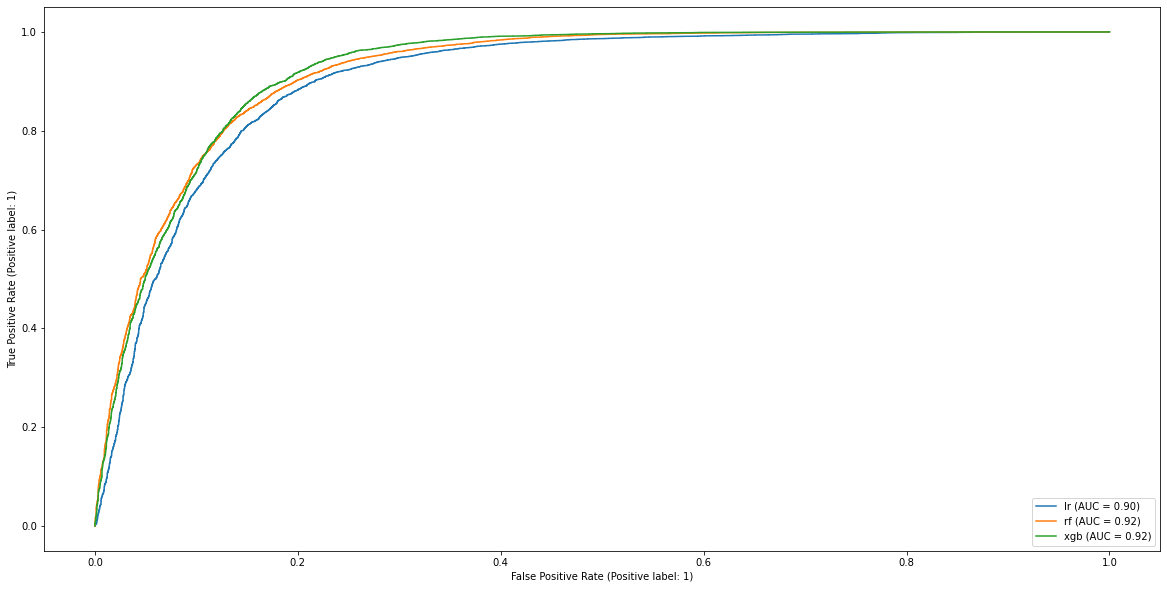

In [183]:
results, display = get_scores(data, target_specificty=0.7)

results.to_pickle("mimic-iv/na_results.pkl")
ft_importance.to_pickle("mimic-iv/na_feature_importance.pkl")

In [184]:
results

,metric,lr,rf,xgb
0,AUROC,0.904243,0.920111,0.922534
1,Sensitivity,0.947998,0.960412,0.973943
2,Specificity,0.700000,0.700000,0.700000
3,F1,0.881735,0.888199,0.895159


## KNN Imputation

In [119]:
data = pd.read_pickle("mimic-iii/Feature_Matrix_MIMIC_with_missing_values_extended.pkl")
data = data.drop(columns=EXTENDED)
data = data.drop(columns=['po2', 'pco2'])
data = data.sample(frac=1)

print(f"Total Samples: {len(data)}")
print(f"RFD: {len(data[data['outcome']==1])}")
print(f"Not RFD: {len(data[data['outcome']==0])}")

Total Samples: 16350
RFD: 9640
Not RFD: 6710


In [120]:
data, ft_importance = get_regression(data, impute=True)

data, ft_importance = get_random_forest(data, n_jobs=12, ft_importance=ft_importance, impute=True)

data, ft_importance = get_xgb(data, ft_importance=ft_importance, impute=True)

/Users/azhar.sultan/opt/anaconda3/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/azhar.sultan/opt/anaconda3/envs/default/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'criterion': 'entropy', 'max_depth': 22, 'max_features': 'auto', 'n_estimators': 2000}
SCORE:                                                                                                                                                                                                              
0.8685966413123593                                                                                                                                                                                                  
SCORE:                                                                                                                                                                                                              
0.8669731337258062                                                                                                                                                                                                  
SCORE:                                                      

In [121]:
data, ft_importance = get_xgb(data, tag="xgb_noimpute", ft_importance=ft_importance, impute=False)

SCORE:                                                                                                                                                                                                              
0.8672973128563781                                                                                                                                                                                                  
SCORE:                                                                                                                                                                                                              
0.8649256244727906                                                                                                                                                                                                  
SCORE:                                                                                                                                              

0.6320441158702913 [0.3        0.30014903] [0.63204412 0.63198584]
0.5699984485475158 [0.29985097 0.30029806] [0.57017122 0.5696529 ]
0.5260656774044036 [0.29970194 0.30029806] [0.5263953  0.52573603]
0.5086182355880737 [0.3        0.30014903] [0.50861824 0.5085843 ]


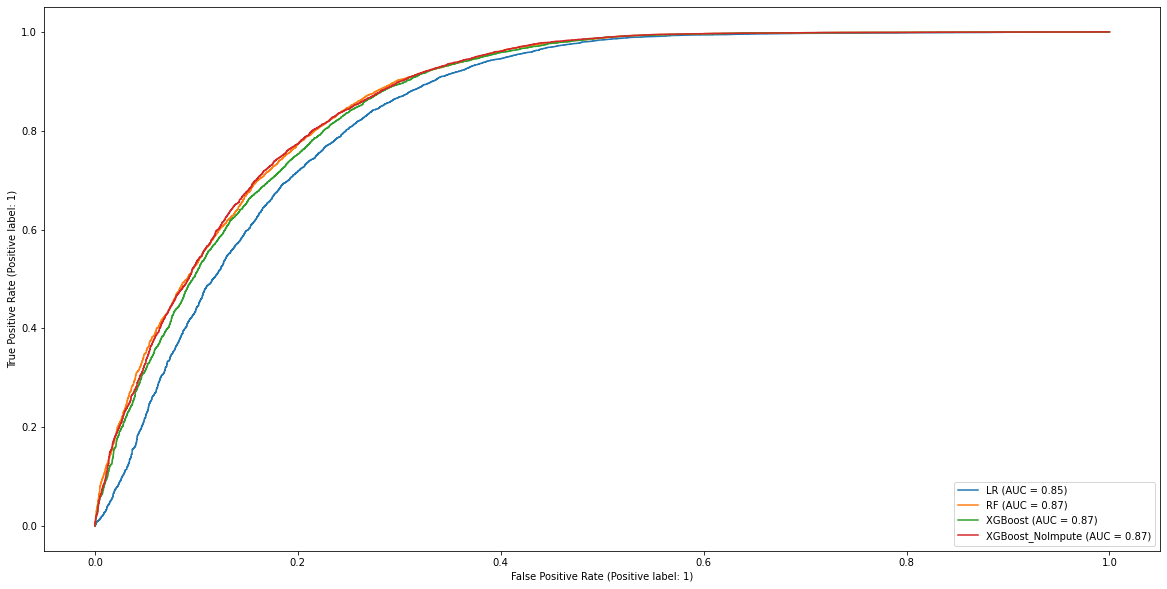

In [128]:
data = data.rename(columns={"xgb_noimpute_pred": "XGBoost_NoImpute_pred"})
results, display = get_scores(data, target_specificty=0.7)

results.to_pickle("mimic-iii/impute_results.pkl")
ft_importance.to_pickle("mimic-iii/impute_feature_importance.pkl")

In [129]:
results

,metric,LR,RF,XGBoost,XGBoost_NoImpute
0,AUROC,0.847493,0.873137,0.867322,0.873008
1,Sensitivity,0.868361,0.903008,0.894398,0.899066
2,Specificity,0.700000,0.700000,0.700000,0.700000
3,F1,0.836097,0.855150,0.850464,0.853051


In [130]:
results.set_index("metric", drop=True).transpose().to_clipboard(float_format='%1.3f')

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

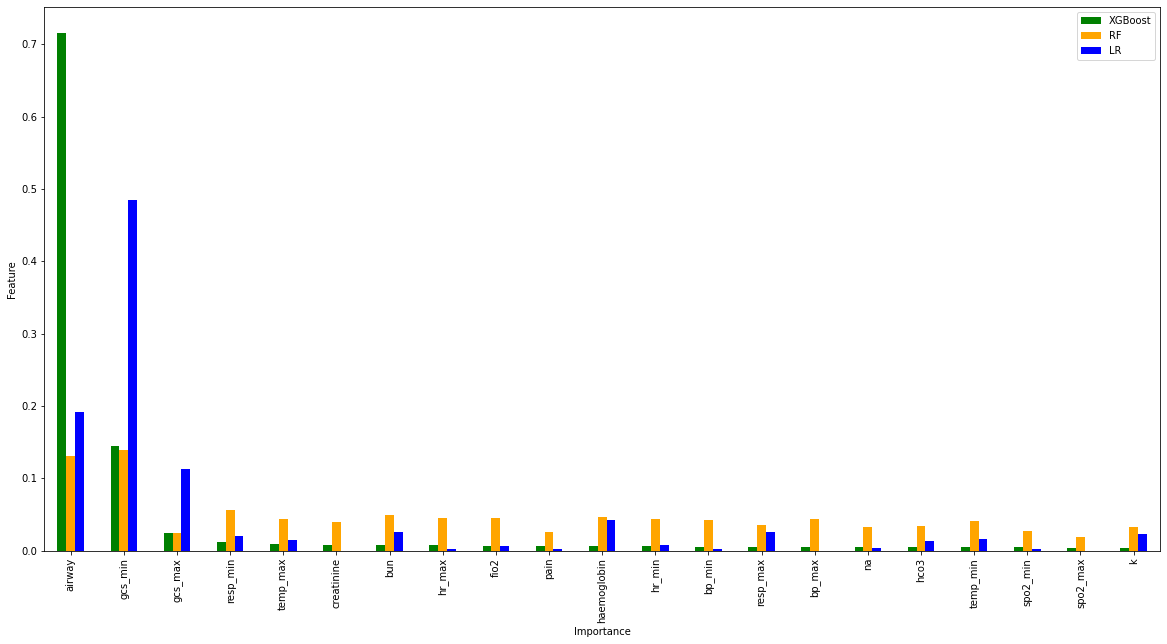

In [132]:
ft_importance.set_index("features").sort_values("XGBoost", ascending=False)[["XGBoost", "RF", "LR"]].plot(
    kind="bar", xlabel="Importance", ylabel="Feature", color=["green", "orange", "blue"])

## KNN Imputation - NA Attribute

In [75]:
data = pd.read_pickle("mimic-iv/micu_Feature_Matrix_MIMIC_with_missing_values_extended.pkl")
data = data.drop(columns=EXTENDED)
data = data.drop(columns=['po2', 'pco2'])
data = data.sample(frac=1)

print(f"Total Samples: {len(data)}")
print(f"RFD: {len(data[data['outcome']==1])}")
print(f"Not RFD: {len(data[data['outcome']==0])}")

Total Samples: 16133
RFD: 9502
Not RFD: 6631


In [76]:
data, ft_importance = get_regression(data, impute=True, na_indicator=True)

data, ft_importance = get_random_forest(data, n_jobs=12, ft_importance=ft_importance, impute=True, na_indicator=True)

data, ft_importance = get_xgb(data, ft_importance=ft_importance, impute=True, na_indicator=True)

/Users/azhar.sultan/opt/anaconda3/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/azhar.sultan/opt/anaconda3/envs/default/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'criterion': 'entropy', 'max_depth': 24, 'max_features': 'auto', 'n_estimators': 1000}
SCORE:                                                                                                                                                                                                                
0.9258861798599993                                                                                                                                                                                                    
SCORE:                                                                                                                                                                                                                
0.9273343533511835                                                                                                                                                                                                    
SCORE:                                              

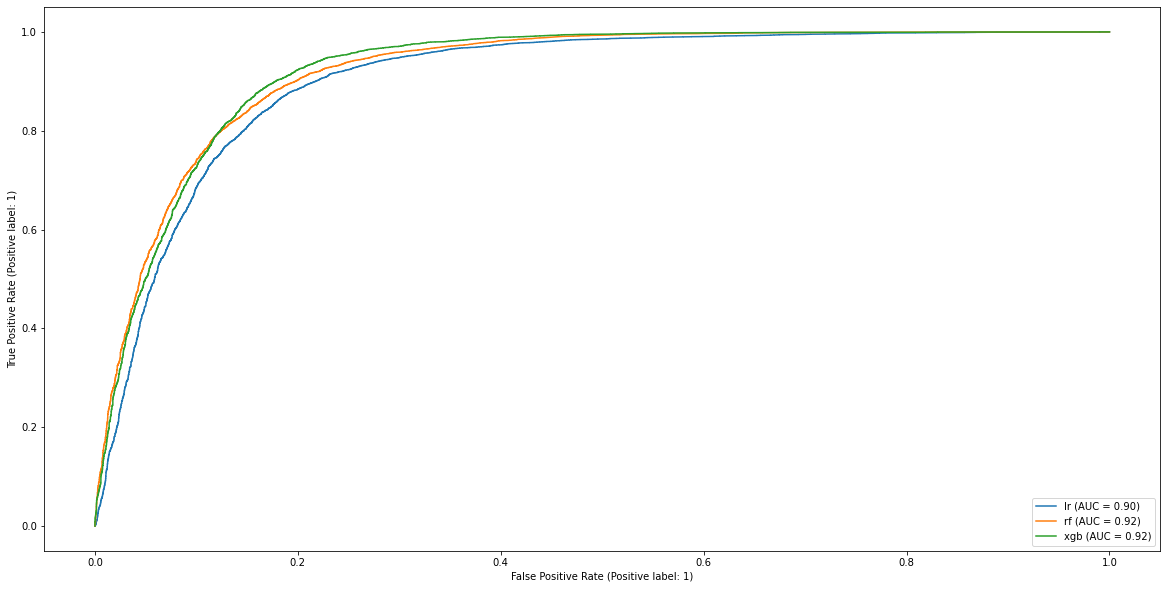

In [77]:
results, display = get_scores(data, target_specificty=0.7)

results.to_pickle("mimic-iv/impute_attribute_results.pkl")
#ft_importance.to_pickle("mimic-iv/impute_feature_importance.pkl")

In [78]:
results

,metric,lr,rf,xgb
0,AUROC,0.904818,0.920933,0.923049
1,Sensitivity,0.947906,0.959061,0.970953
2,Specificity,0.700000,0.700000,0.700000
3,F1,0.878817,0.884500,0.890669


## Final

In [78]:
EXTENDED_DROP = ['ethnicity', 'gender', 'admission_age', 'bmi']


In [112]:
data = pd.read_pickle("mimic-iv/micu_Feature_Matrix_MIMIC_with_missing_values_extended.pkl")
data = data.drop(columns=EXTENDED_DROP)
data = data.drop(columns=['po2', 'pco2', 'pain', 'na', 'k'])
data = data.sample(frac=1)

print(f"Total Samples: {len(data)}")
print(f"RFD: {len(data[data['outcome']==1])}")
print(f"Not RFD: {len(data[data['outcome']==0])}")

Total Samples: 16133
RFD: 9502
Not RFD: 6631


In [113]:
data, ft_importance = get_regression(data, impute=True, na_indicator=False)

data, ft_importance = get_random_forest(data, n_jobs=12, ft_importance=ft_importance, impute=True, na_indicator=False)

data, ft_importance = get_xgb(data, ft_importance=ft_importance, impute=True, na_indicator=False)

/Users/azhar.sultan/opt/anaconda3/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/azhar.sultan/opt/anaconda3/envs/default/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
SCORE:                                                                                                                                                                                                                
0.9200946939513377                                                                                                                                                                                                    
SCORE:                                                                                                                                                                                                                
0.9214194023093494                                                                                                                                                                                                    
SCORE:                                               

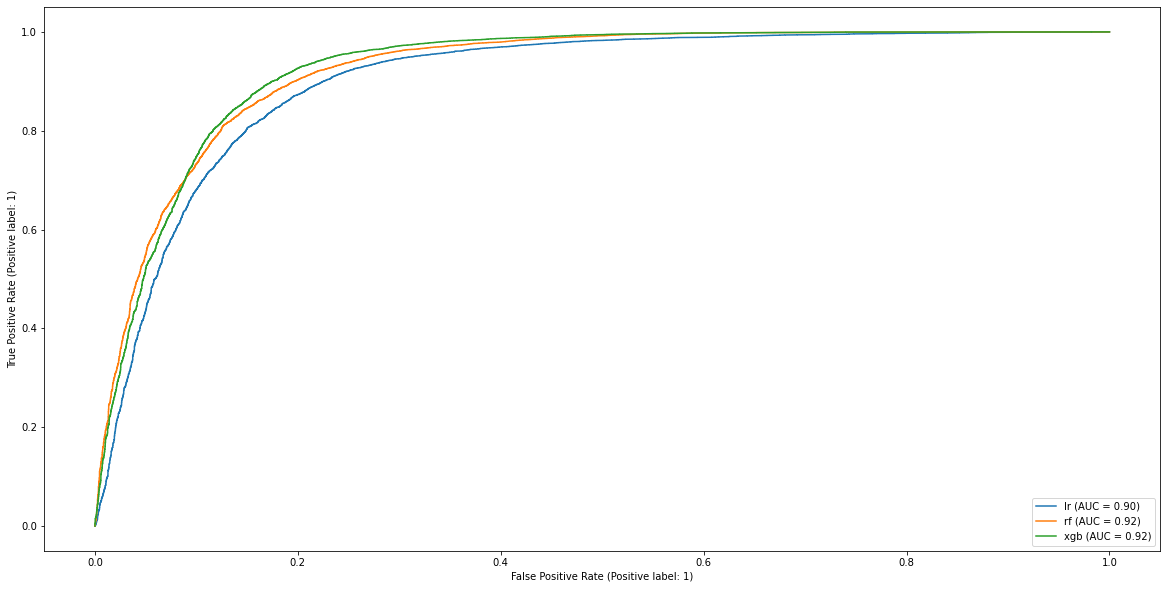

In [115]:
results, display = get_scores(data, target_specificty=0.7)
results.to_pickle("mimic-iv/final_impute_results.pkl")
ft_importance.to_pickle("mimic-iv/final_impute_ft_importance.pkl")

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

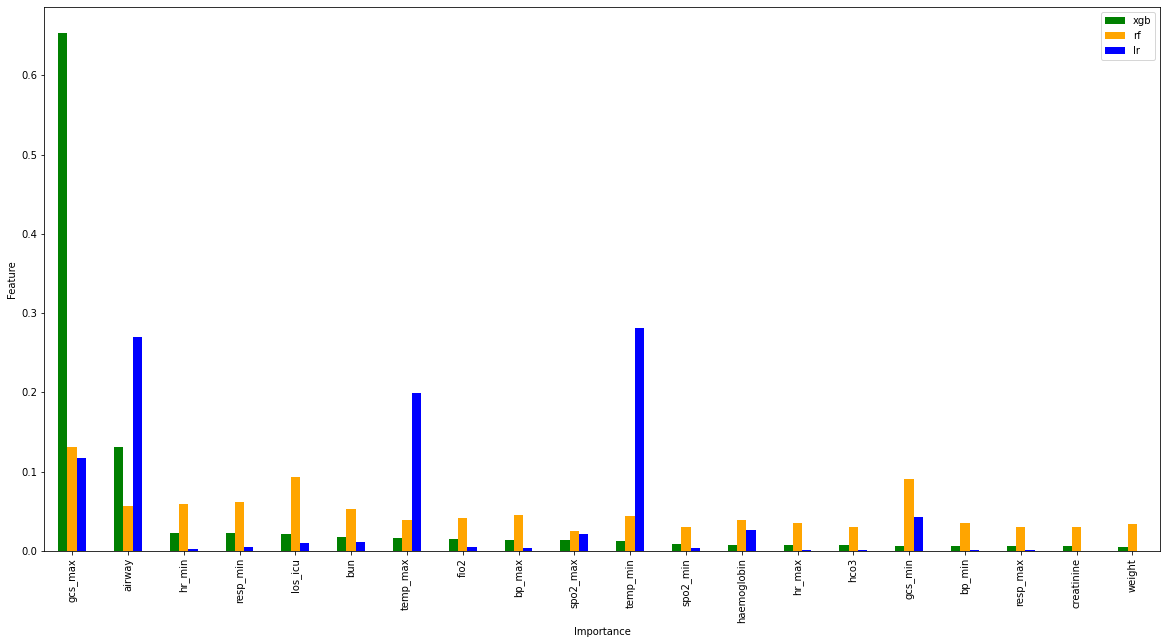

In [123]:
ft_importance.set_index("features").sort_values("xgb", ascending=False)[["xgb", "rf", "lr"]].plot(kind="bar", xlabel="Importance", ylabel="Feature", color=["green", "orange", "blue"])

In [96]:
results

,metric,lr,rf,xgb
0,AUROC,0.901975,0.921667,0.923730
1,Sensitivity,0.946117,0.961587,0.969796
2,Specificity,0.700000,0.700000,0.700000
3,F1,0.877887,0.885969,0.890080


## FiO2 Missingness Ablation

In [149]:
data = pd.read_pickle("mimic-iv/micu_Feature_Matrix_MIMIC_with_missing_values_extended.pkl")
data = data.drop(columns=EXTENDED_DROP)
data = data.drop(columns=['po2', 'pco2', 'pain', 'na', 'k'])
data["fio2_na"] = data["fio2"].isna()
data = data.sample(frac=1)

print(f"Total Samples: {len(data)}")
print(f"RFD: {len(data[data['outcome']==1])}")
print(f"Not RFD: {len(data[data['outcome']==0])}")

Total Samples: 16133
RFD: 9502
Not RFD: 6631


In [151]:
data, _ = get_xgb(data.drop(columns=["fio2_na"]), ft_importance=None, impute=True, na_indicator=False)
data, _ = get_xgb(data, tag="xgb_na", ft_importance=None, impute=True, na_indicator=False)


SCORE:                                                                                                                                                                                                              
0.9234252491007895                                                                                                                                                                                                  
SCORE:                                                                                                                                                                                                              
0.9224652435060549                                                                                                                                                                                                  
SCORE:                                                                                                                                              

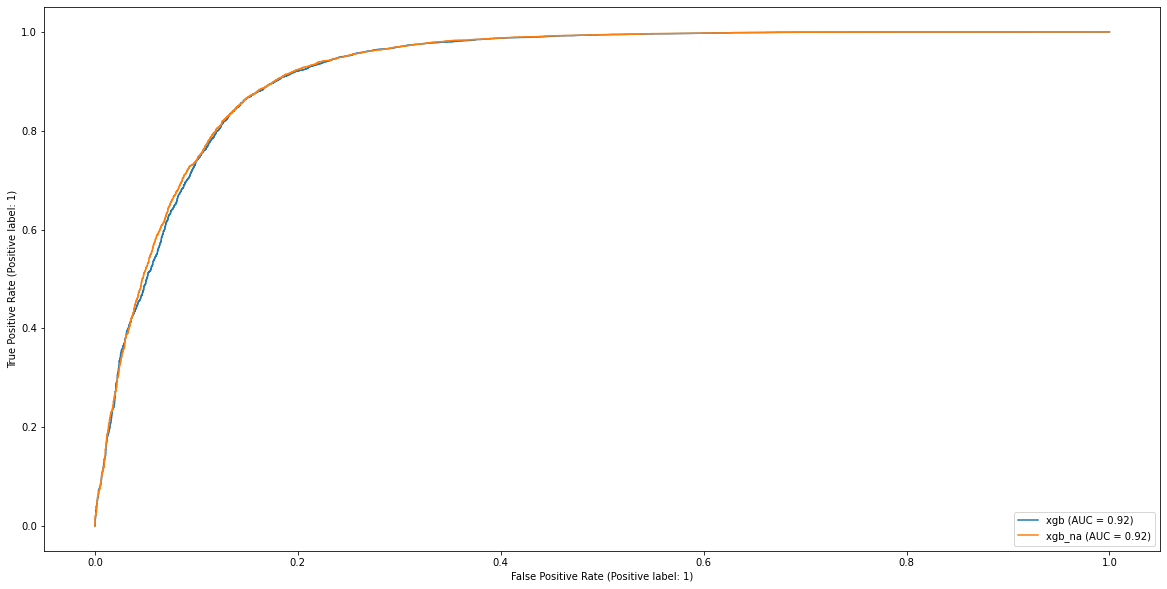

In [154]:
results, display = get_scores(data[[]], target_specificty=0.7)

In [153]:
results

,metric,xgb,xgb_na
0,AUROC,0.922888,0.924557
1,Sensitivity,0.970006,0.969901
2,Specificity,0.700000,0.700000
3,F1,0.890187,0.890177


0.9065806150436402 [0.19986851 0.20052597] [0.90658134 0.9065777 ]
0.8936348676681518 [0.19986851 0.20052597] [0.8936585  0.89354026]
0.21125356356302902 [0.19921722 0.20039139] [0.21193132 0.21091469]


,metric,Complete
0,AUROC,0.944559
1,Sensitivity,0.943418
2,Specificity,0.800000
3,F1,0.804894


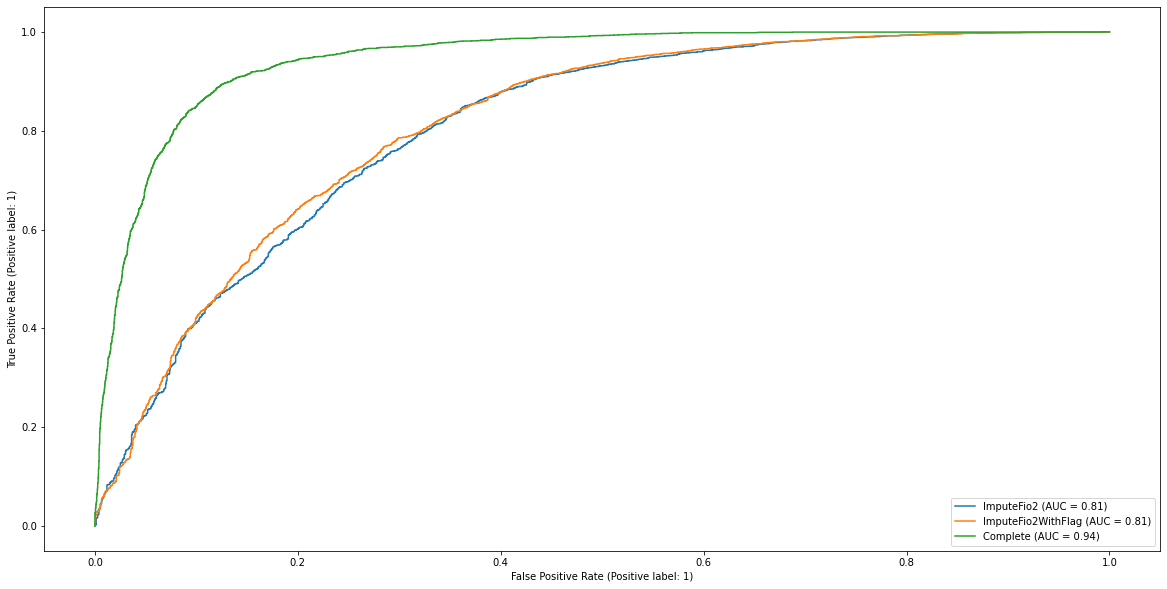

In [233]:
results_impute, display = get_scores(data[data["fio2"].isna()].rename(columns={"xgb_pred": "ImputeFio2_pred"})[["ImputeFio2_pred","outcome"]], target_specificty=0.8)
results_impute_na, display = get_scores(data[data["fio2"].isna()].rename(columns={"xgb_na_pred": "ImputeFio2WithFlag_pred"})[["ImputeFio2WithFlag_pred","outcome"]], target_specificty=0.8, ax=display.ax_)
results_cc, display = get_scores(data[~data["fio2"].isna()].rename(columns={"xgb_pred": "Complete_pred"})[["Complete_pred","outcome"]], target_specificty=0.8, ax=display.ax_)
results_cc

In [234]:
results = results_impute
results["ImputeFio2WithFlag"] = results_impute_na["ImputeFio2WithFlag"]
results["Complete"] = results_cc["Complete"]

In [235]:
results[["metric", "ImputeFio2", "ImputeFio2WithFlag", "Complete"]].set_index("metric", drop=True).transpose()

metric,AUROC,Sensitivity,Specificity,F1
ImputeFio2,0.806488,0.601121,0.8,0.730927
ImputeFio2WithFlag,0.812832,0.641368,0.8,0.761239
Complete,0.944559,0.943418,0.8,0.804894


In [222]:
fpr, tpr, thresholds = precision_recall_curve(data[~data["fio2"].isna()]["outcome"], data[~data["fio2"].isna()]["xgb_pred"])

(array([5110.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2545.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

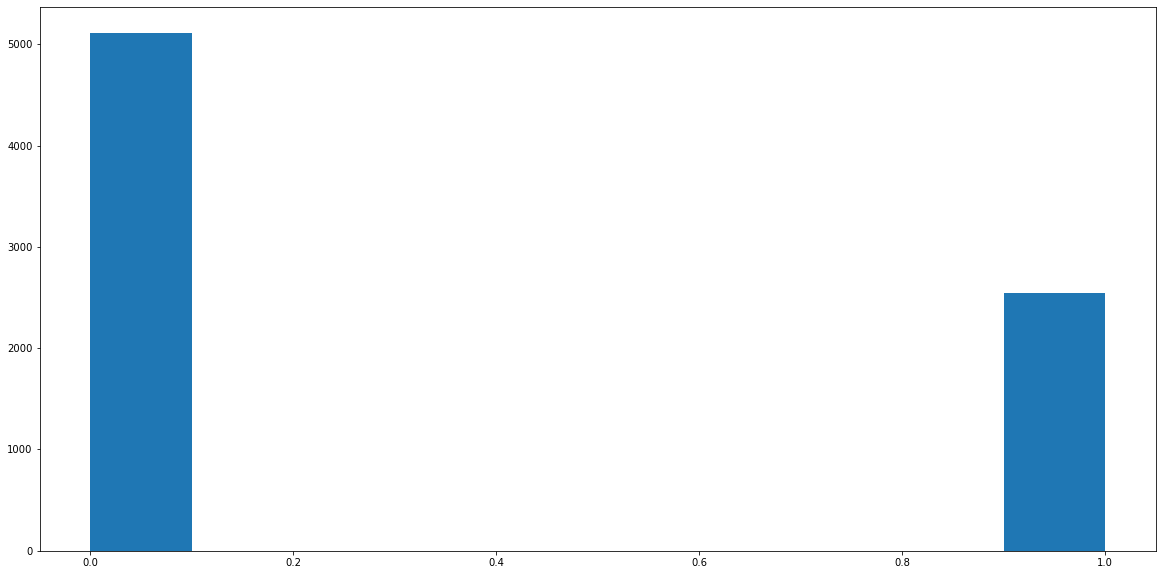

In [229]:
plt.hist(data[~data["fio2"].isna()]["outcome"])

## Extreme Gradient Boosting

In [110]:
data = pd.read_pickle('mimic-iv/micu_Feature_Matrix_MIMIC_with_missing_values_extended.pkl')
data = data.drop(columns=["gcs_max", "k", "na", "pain", "hr_max", "los_icu"])
data = data.dropna(how='any')
data = data.sample(frac=1)

print(f"Total Samples: {len(data)}")
print(f"RFD: {len(data[data['outcome']==1])}")
print(f"Not RFD: {len(data[data['outcome']==0])}")

Total Samples: 16133
RFD: 9502
Not RFD: 6631


In [111]:
data, ft_xgb_importance = get_xgb(data, hyperparams)

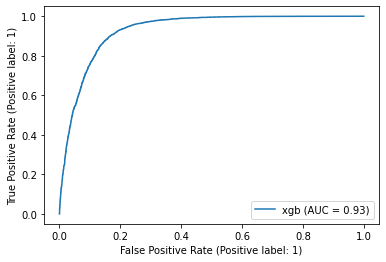

In [112]:
results_xgb, display = get_scores(data, tag="xgb")

In [113]:
results_xgb

{'model': 'xgb',
 'auroc': 0.9286261032410577,
 'sensitivity': 0.9205430435697748,
 'specificity': 0.8116422862313376,
 'f1_score': 0.8972202277156632,
 'accuracy': 0.8757825574908572}

In [114]:
ft_xgb_importance

,features,xgb_importance
15,airway,0.545319
2,gcs_min,0.194149
14,fio2,0.049995
13,bun,0.026065
4,resp_min,0.022266
7,spo2_max,0.019302
8,temp_min,0.017934
3,hr_min,0.017413
1,bp_max,0.017214
9,temp_max,0.014135


In [8]:
x = data.drop(columns=['STAY_ID', 'outcome'])
y = data['outcome']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)#, random_state = 670)

In [29]:
def objective(space, data):
    X_train, X_test, y_train, y_test = data
    clf=XGBClassifier(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],min_child_weight=int(space['min_child_weight']), reg_lambda = space['reg_lambda'],
                    colsample_bytree=space['colsample_bytree'], use_label_encoder=False, eval_metric="auc",  
                    early_stopping_rounds=20, n_jobs=10)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, verbose=False)
    

    pred = clf.predict_proba(X_test)
    accuracy = roc_auc_score(y_test, pred[:,1])
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }



In [50]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from functools import partial
space={'max_depth': hp.quniform("max_depth", 22, 30, 1),
        'gamma': hp.uniform ('gamma', 2,3),
        'reg_alpha' : hp.quniform('reg_alpha', 11,15,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0.5,0.7),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,0.6),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 3, 1),
        'n_estimators': hp.quniform('n_estimators',1000,1200,1),
        'seed': 0
    }

In [51]:
trials = Trials()
objective = partial(objective, data=(X_train, X_test, y_train, y_test))
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                                                                                                                
0.9005197884053889                                                                                                                                                                                                    
SCORE:                                                                                                                                                                                                                
0.9027497030298048                                                                                                                                                                                                    
SCORE:                                                                                                                                      

In [9]:
hp.quniform??

Signature: hp.quniform(label, *args, **kwargs)
Docstring: <no docstring>
Source:   
@validate_label
@validate_distribution_range
def hp_quniform(label, *args, **kwargs):
    return scope.float(scope.hyperopt_param(label, scope.quniform(*args, **kwargs)))
File:      ~/opt/anaconda3/envs/default/lib/python3.9/site-packages/hyperopt/pyll_utils.py
Type:      function


In [35]:
hyperparams = {'colsample_bytree': 0.5471188437379702,
 'gamma': 2.7939218704643576,
 'max_depth': 30,
 'min_child_weight': 1,
 'n_estimators': 1102,
 'reg_alpha': 13,
 'reg_lambda': 0.680932222571607}

In [83]:
hyperparams = {'colsample_bytree': 0.8913783039765838,
 'gamma': 1.0191093530882969,
 'max_depth': 22,
 'min_child_weight': 11.0,
 'n_estimators': 936,
 'reg_alpha': 16.0,
 'reg_lambda': 0.74363084500733}

In [248]:
xbgc = XGBClassifier(use_label_encoder=False, **best_hyperparams)

In [249]:
evaluation = [( X_test, y_test)]
xbgc.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=500,verbose=False)

/Users/azharsultan/miniconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8913783039765838,
              enable_categorical=False, gamma=1.0191093530882969, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=22,
              min_child_weight=11.0, missing=nan, monotone_constraints='()',
              n_estimators=936, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=16.0, reg_lambda=0.74363084500733,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [250]:
pred = xbgc.predict_proba(X_test)

In [251]:
print(classification_report(y_test, pred[:,1]>0.4))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       579
           1       0.74      0.87      0.80       363

    accuracy                           0.83       942
   macro avg       0.82      0.84      0.83       942
weighted avg       0.84      0.83      0.84       942



In [252]:
roc_auc_score(y_test, pred[:,1])

0.9066072881428511

In [239]:
confusion_matrix(y_test, pred[:,1]>0.33)

array([[459, 122],
       [ 39, 322]])

In [253]:
ft_importance = pd.DataFrame()
ft_importance['feeatures'] = x.columns
ft_importance['importance'] = xbgc.feature_importances_
ft_importance.sort_values(by='importance', ascending=False)

,feeatures,importance
3,gcs_max,0.555083
18,airway,0.074550
6,resp_min,0.047069
11,temp_max,0.044620
17,bun,0.044032
4,hr_min,0.033209
10,temp_min,0.028845
9,spo2_max,0.028750
15,haemoglobin,0.025309
1,bp_max,0.021874


## Visualizations

In [39]:
import matplotlib.pyplot as plt

In [49]:
ft_importance = ft_importance.sort_values(by="importance", ascending=False)

Text(0.5, 1.0, 'RandomForest Feature Importance')

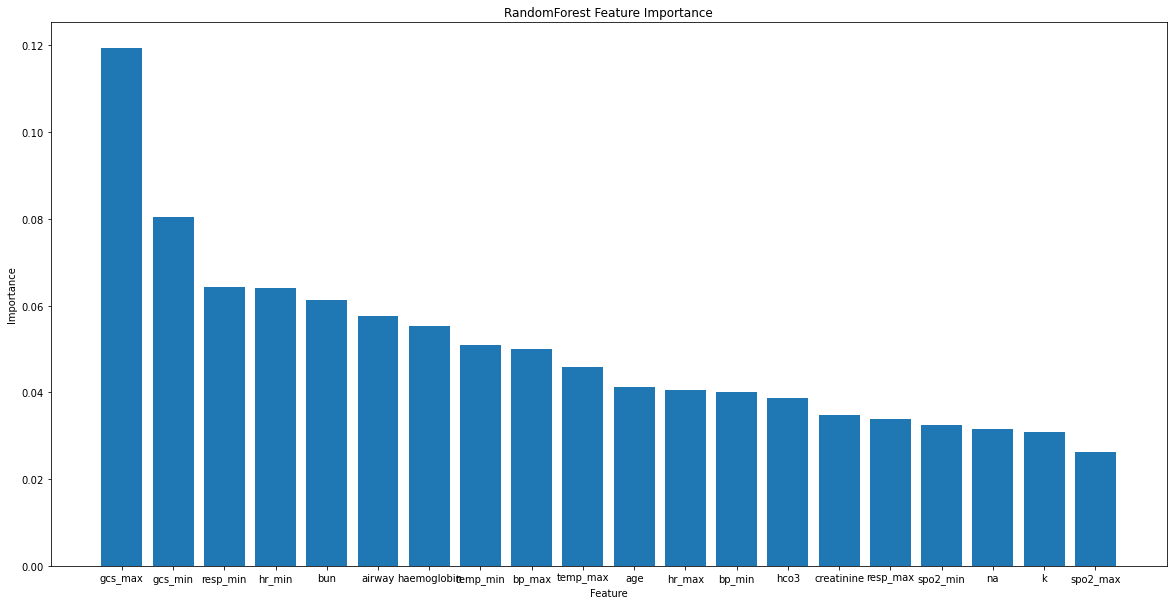

In [52]:
plt.figure(figsize=(20,10))
plt.bar(ft_importance["feeatures"], ft_importance["importance"])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("RandomForest Feature Importance")

In [61]:
stay_data[stay_data.stay_id == 37955663]

,stay_id,gender,admission_age,los_icu,bmi,weight,ethnicity
59330,37955663,1,79,12.46,22.6318,67.5,3


In [59]:
data

,STAY_ID,bp_min,bp_max,gcs_min,hr_min,resp_min,resp_max,spo2_min,spo2_max,temp_min,...,hco3,haemoglobin,creatinine,bun,fio2,airway,po2,pco2,outcome,xgb_pred
8364,36519653,104.0,140.0,7.0,53.0,12.0,25.0,98.0,100.0,36.722222,...,26.0,14.3,88.420,2.8568,40.0,1.0,NaN,NaN,1,0.922277
2044,31612048,84.0,100.0,14.0,106.0,17.0,28.0,94.0,99.0,36.611111,...,20.0,11.5,53.052,4.9994,NaN,0.0,NaN,NaN,0,0.638106
10824,38519882,97.0,143.0,14.0,61.0,20.0,25.0,93.0,100.0,37.055556,...,29.0,8.8,88.420,4.2852,NaN,0.0,NaN,NaN,1,0.806112
4601,33596522,89.0,133.0,10.0,67.0,16.0,22.0,90.0,94.0,36.333333,...,24.0,10.9,53.052,4.6423,NaN,0.0,NaN,NaN,1,0.920339
4842,33771550,116.0,116.0,15.0,62.0,13.0,17.0,99.0,99.0,36.000000,...,27.0,14.2,61.894,6.4278,NaN,0.0,NaN,NaN,1,0.902670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4371,33414220,101.0,147.0,15.0,55.0,19.0,43.0,97.0,100.0,36.666667,...,22.0,9.3,70.736,8.9275,NaN,0.0,NaN,NaN,1,0.942195
5851,34569737,98.0,178.0,15.0,62.0,18.0,35.0,96.0,98.0,36.111111,...,27.0,8.5,88.420,11.0701,NaN,0.0,NaN,NaN,1,0.763905
13716,1067,98.0,128.0,15.0,67.0,12.0,20.0,98.0,99.0,36.722222,...,24.0,8.9,26.526,6.0707,50.0,1.0,NaN,NaN,0,0.240208
14719,2070,136.0,159.0,13.0,91.0,28.0,33.0,97.0,98.0,36.055556,...,22.0,11.8,70.736,10.3559,NaN,0.0,NaN,NaN,0,0.546867


In [62]:
from copy import deepcopy
stay_data = stay_data.set_index("stay_id", drop=True)

#stayid_mapping.apply(row:)

In [64]:
stay_data.loc[38099047].to_dict()

{'gender': 1.0,
 'admission_age': 84.0,
 'los_icu': 9.79,
 'bmi': 28.56331271304128,
 'weight': 90.5,
 'ethnicity': 3.0}

In [65]:
stayid_mapping

,Xi,STAY_ID,new_ID
0,4.0,38099047,0
1,4.0,33570939,1
2,4.0,37157052,2
3,4.0,30954212,3
4,4.0,32770057,4
...,...,...,...
659,8.0,33369539,5193
660,8.0,33700270,5194
661,8.0,34160871,5195
662,8.0,37955663,5196


In [10]:
1.0 == 1

True

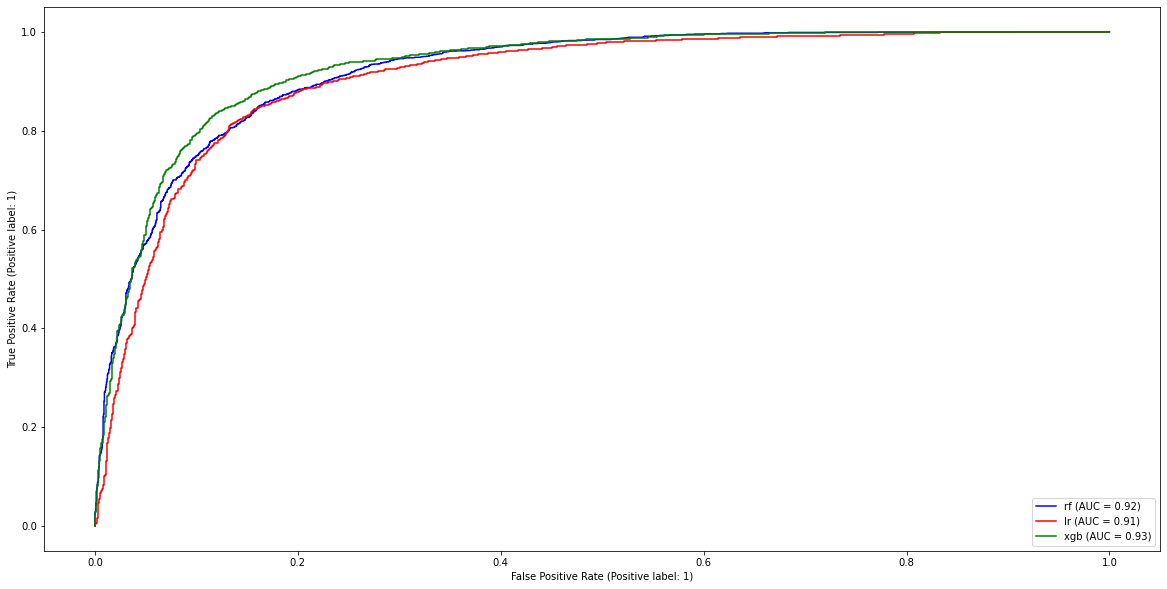

In [112]:
plt.rcParams["figure.figsize"] = (20,10)
roc_display = RocCurveDisplay.from_predictions(data['outcome'], data['rf_pred'], name="rf", ax=None, color='blue')
roc_display = RocCurveDisplay.from_predictions(data['outcome'], data['lr_pred'], name="lr", ax=roc_display.ax_, color='red')
roc_display = RocCurveDisplay.from_predictions(data['outcome'], data['xgb_pred'], name="xgb", ax=roc_display.ax_, color='green')

<AxesSubplot:xlabel='False Positive Rate (Positive label: 1)', ylabel='True Positive Rate (Positive label: 1)'>

In [106]:
fig = plt.Figure(figsize=(20,10))

In [115]:
a = roc_curve(data['outcome'], data['rf_pred'])

In [127]:
idx = np.where(a[0]>=0.3)[0][0]

In [128]:
s = np.interp(0.3, a[0][idx-1:idx+1], a[1][idx-1:idx+1])

In [129]:
s

0.9459016393442623

In [135]:
a[2]

array([1.9917664 , 0.9917664 , 0.95739582, ..., 0.0045    , 0.003     ,
       0.0025    ])

In [153]:
x = drop_cols(data, cols2drop=None)
    
scaler = StandardScaler()
scaler = scaler.fit(x)
transformed_x = scaler.transform(x)

In [156]:

x.columns

Index(['bp_min', 'bp_max', 'gcs_min', 'gcs_max', 'hr_min', 'hr_max',
       'resp_min', 'resp_max', 'spo2_min', 'spo2_max', 'temp_min', 'temp_max',
       'na', 'k', 'hco3', 'haemoglobin', 'creatinine', 'bun', 'pain', 'fio2',
       'airway'],
      dtype='object')

In [157]:
ft_importance

,features,rf_importance
2,gcs_min,0.101716
16,bun,0.076705
5,resp_min,0.075458
9,temp_min,0.073914
3,hr_min,0.063871
10,temp_max,0.058956
1,bp_max,0.057465
14,haemoglobin,0.048008
19,airway,0.046982
4,hr_max,0.042572


In [239]:
len(data[data["STAY_ID"]>30000000]), data[data["STAY_ID"]>30000000]["outcome"].sum()

(11627, 9502)

<BarContainer object of 15 artists>

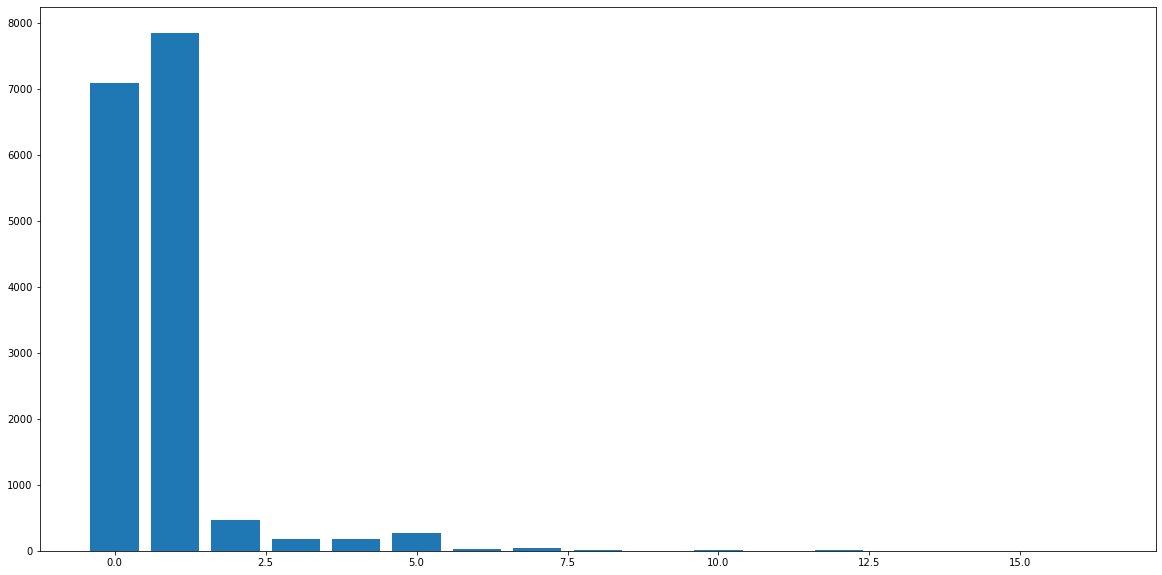

In [251]:
values, counts = np.unique(data.isna().sum(axis=1), return_counts=True)
plt.bar(values, counts)

In [253]:
counts

array([7090, 7851,  465,  172,  184,  275,   34,   35,    5,    4,    7,
          2,    5,    3,    1])

In [255]:
values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 16])